# Why need wavelets

- We compare decomposition of signals with and without time-frequency localization.
- Also we visualize the Fourier transform of a signal in 3D, providing a understanding about scalogram.

In [1]:
from typing import Callable

import numpy as np
from scipy.integrate import quad


def fourier_transform(
    func: Callable[[float], float], t_min: float, t_max: float, normalize: bool = False
) -> Callable[[float], float]:
    def func_with_hat(f: float) -> float:
        integrand = lambda t: func(t) * np.exp(-2j * np.pi * f * t)
        integral: complex = quad(integrand, t_min, t_max, complex_func=True)[0]
        if normalize:
            integral /= t_max - t_min
        return integral.real

    return func_with_hat

Manim Community v0.18.1

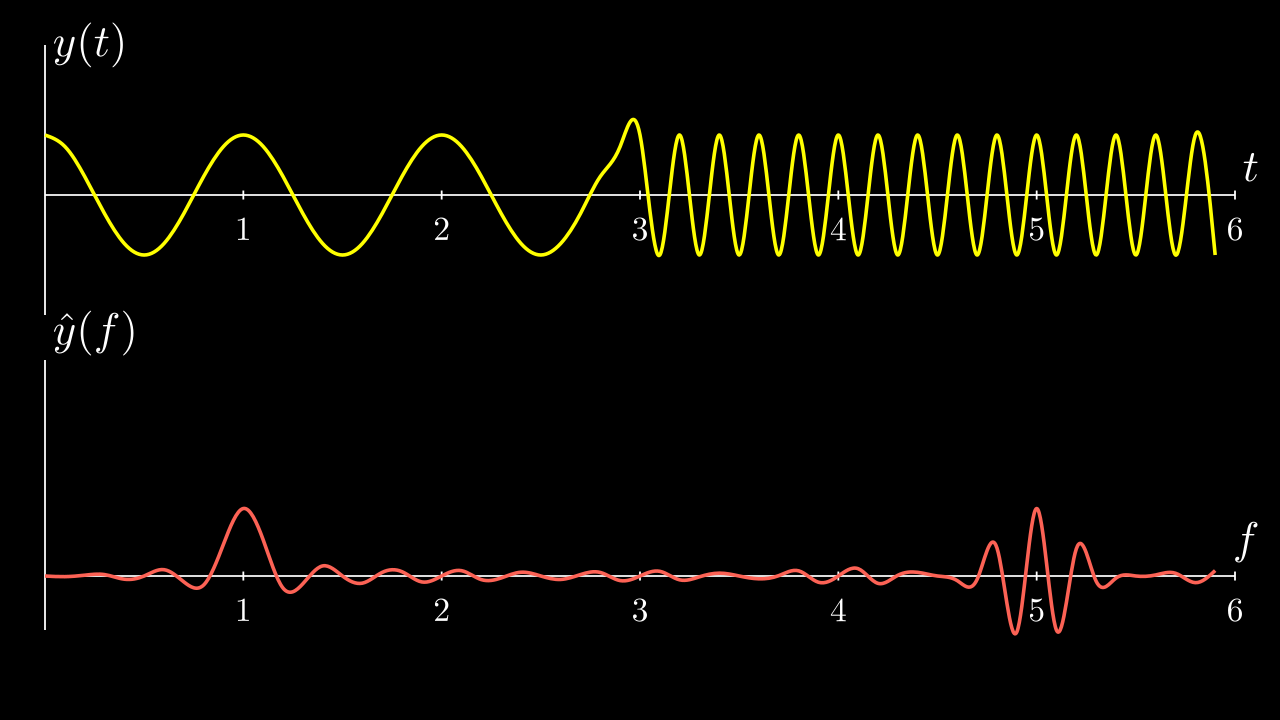

In [3]:
from manim import *


class FourierLacksTimeLocality(Scene):
    def construct(self):
        # time global function
        func_1 = lambda t: np.cos(1 * TAU * t) + np.cos(5 * TAU * t)

        # time local function
        func_2 = lambda t: np.cos(1 * TAU * t) * (t < 3) + np.cos(5 * TAU * t) * (t >= 3)

        self.illustrate_fourier_transform(func_1)
        self.wait(1)
        self.clear()
        self.illustrate_fourier_transform(func_2)
        self.wait(1)

    def illustrate_fourier_transform(self, func: Callable[[float], float]):
        t_min, t_max = 0, 6
        func_hat = fourier_transform(func, t_min, t_max, True)

        time_axes = Axes(
            x_range=[t_min, t_max, 1],
            y_range=[-2, 2.5, 0.5],
            y_axis_config={"include_ticks": False},
            tips=False,
        )
        time_axes.stretch_to_fit_height(3)
        time_axes.stretch_to_fit_width(config.frame_width - LARGE_BUFF)
        time_axes.to_corner(UL)
        time_axes_labels = time_axes.get_axis_labels(x_label="t", y_label="y(t)")
        time_axes.get_x_axis().add_numbers()
        time_graph = time_axes.plot(func, [t_min, t_max - SMALL_BUFF], color=YELLOW)

        freq_axes = Axes(
            x_range=[0, 6, 1],
            y_range=[-0.2, 0.8, 0.2],
            y_axis_config={"include_ticks": False},
            tips=False,
        )
        freq_axes.stretch_to_fit_height(3)
        freq_axes.stretch_to_fit_width(config.frame_width - LARGE_BUFF)
        freq_axes.next_to(time_axes, DOWN, buff=MED_LARGE_BUFF).to_edge(LEFT)
        freq_axes_labels = freq_axes.get_axis_labels(x_label="f", y_label="\\hat{y}(f)")
        freq_axes.get_x_axis().add_numbers()
        freq_graph = freq_axes.plot(func_hat, [0, 6 - SMALL_BUFF], color=RED)

        self.add(time_axes, time_axes_labels, freq_axes, freq_axes_labels)
        self.play(Create(time_graph))
        self.wait(0.5)
        self.play(ReplacementTransform(time_graph.copy(), freq_graph))
        self.wait(1)

%manim -qm -v WARNING -s FourierLacksTimeLocality

Manim Community v0.18.1

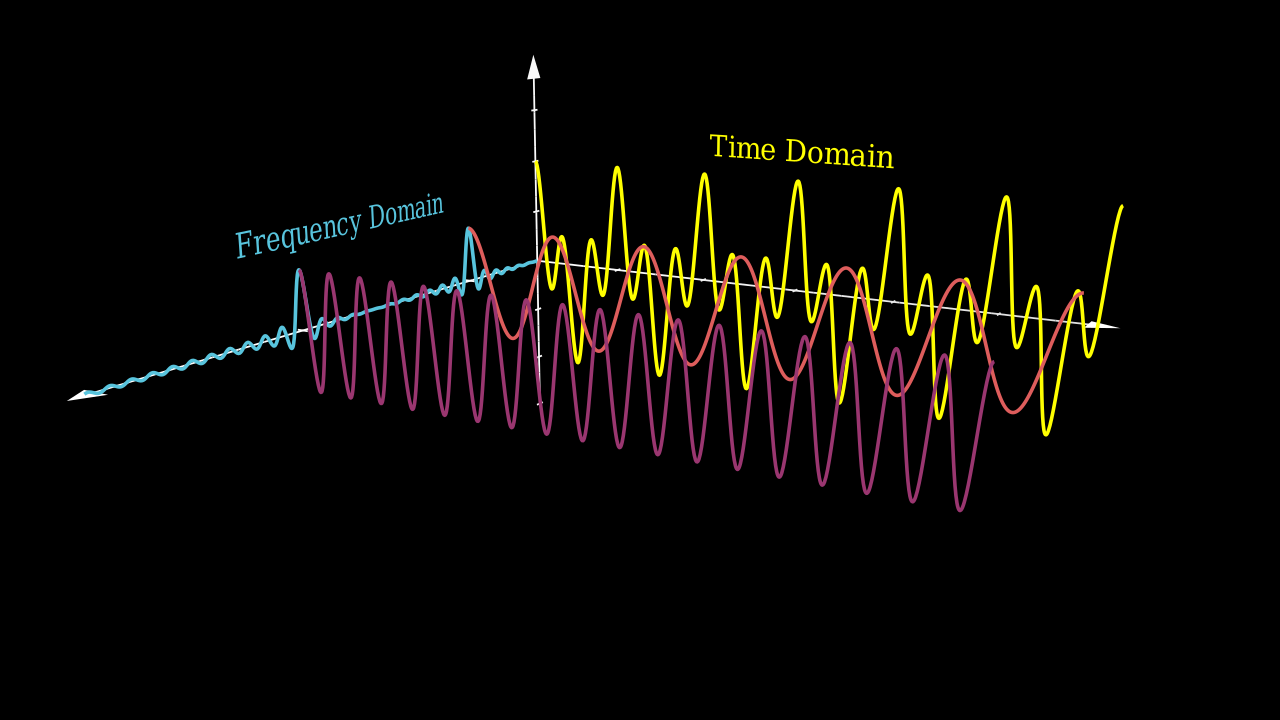

In [5]:
from manim import *
import seaborn as sns


class Fourier3dDecomp(ThreeDScene):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.frequencies = [1, 3]
        self.colors = sns.color_palette("flare", len(self.frequencies)).as_hex()
        self.signal = lambda t: np.sum([np.cos(f * TAU * t) for f in self.frequencies]) / len(self.frequencies)
        self.range = [0, 6]

    def construct(self):
        # Fourier Transform
        ft = fourier_transform(self.signal, *self.range, normalize=True)

        # Create 3D axes
        axes = ThreeDAxes(
            x_range=[0, 5],  # Frequency (x-axis)
            y_range=self.range,  # Time (y-axis)
            z_range=[-1.5, 2, 0.5],  # Amplitude (z-axis)
        )

        # Plot time-domain signal on the yz-plane
        time_graph = axes.plot_parametric_curve(
            lambda t: np.array([0, t, self.signal(t)]),
            t_range=self.range,
            color=YELLOW
        )

        # Stack decompositions parallel to the yz-plane
        decomposition_curves = []
        for freq, color in zip(self.frequencies, self.colors):
            curve = axes.plot_parametric_curve(
                lambda t, f=freq: np.array([f, t, np.cos(2 * np.pi * f * t) / len(self.frequencies)]),
                t_range=self.range,
                color=color,
            )
            decomposition_curves.append(curve)

        # Plot Fourier Transform on the xz-plane
        ft_graph = axes.plot_parametric_curve(
            lambda f: np.array([f, 0, ft(f) * len(self.frequencies)]),
            t_range=[0, 5 - SMALL_BUFF],
            color=BLUE
        )

        # Labels
        time_label = Text("Time Domain", font_size=36, color=YELLOW)
        time_label.next_to(time_graph, OUT, MED_LARGE_BUFF).rotate(90 * DEGREES, UP).rotate(90 * DEGREES, RIGHT)
        ft_label = Text("Frequency Domain", font_size=36, color=BLUE)
        ft_label = ft_label.next_to(ft_graph, OUT, MED_LARGE_BUFF).rotate(90 * DEGREES, RIGHT).rotate(PI, OUT)
        
        # Camera setup and animations
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES, zoom=0.8)
        self.add(axes)
        self.play(Create(time_graph), Write(time_label),
                  Create(ft_graph), Write(ft_label))
        self.wait(1)

        self.play(*[Create(curve) for curve in decomposition_curves], run_time=5, rate_func=linear)
        self.wait(1)


%manim -qm -v WARNING -s Fourier3dDecomp

Manim Community v0.18.1

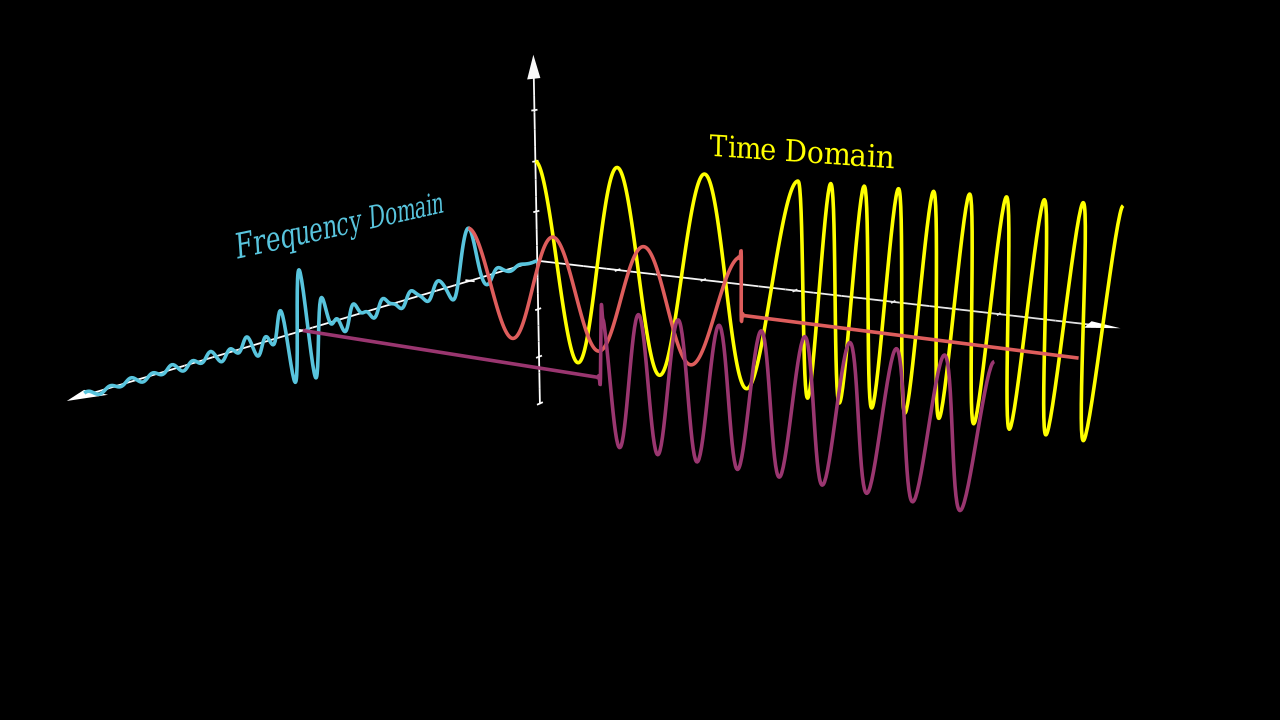

In [6]:
from manim import *
import seaborn as sns


class FourierImagination(ThreeDScene):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.frequencies = [1, 3]
        self.colors = sns.color_palette("flare", len(self.frequencies)).as_hex()
        self.range = [0, 6]
        self.breakpoints = [3]
    
    def signal(self, t):
        freq_range = [t] + self.breakpoints
        freq_range.sort()
        current_index = freq_range.index(t)
        return np.cos(2 * np.pi * self.frequencies[current_index] * t)

    def partial_signal(self, f, t):
        freq_range = [t] + self.breakpoints
        freq_range.sort()
        current_index = freq_range.index(t)
        return np.cos(2 * np.pi * f * t) * (self.frequencies[current_index] == f)

    def construct(self):
        # Fourier Transform
        ft = fourier_transform(self.signal, *self.range, normalize=True)

        # Create 3D axes
        axes = ThreeDAxes(
            x_range=[0, 5],  # Frequency (x-axis)
            y_range=self.range,  # Time (y-axis)
            z_range=[-1.5, 2, 0.5],  # Amplitude (z-axis)
        )

        # Plot time-domain signal on the yz-plane
        time_graph = axes.plot_parametric_curve(
            lambda t: np.array([0, t, self.signal(t)]),
            t_range=self.range,
            color=YELLOW
        )

        # Stack decompositions parallel to the yz-plane
        decomposition_curves = []
        for freq, color in zip(self.frequencies, self.colors):
            curve = axes.plot_parametric_curve(
                lambda t, f=freq: np.array([f, t, self.partial_signal(f,t) / len(self.frequencies)]),
                t_range=self.range,
                color=color,
            )
            decomposition_curves.append(curve)

        # Plot Fourier Transform on the xz-plane
        ft_graph = axes.plot_parametric_curve(
            lambda f: np.array([f, 0, ft(f) * len(self.frequencies)]),
            t_range=[0, 5 - SMALL_BUFF],
            color=BLUE
        )

        # Labels
        time_label = Text("Time Domain", font_size=36, color=YELLOW)
        time_label.next_to(time_graph, OUT, MED_LARGE_BUFF).rotate(90 * DEGREES, UP).rotate(90 * DEGREES, RIGHT)
        ft_label = Text("Frequency Domain", font_size=36, color=BLUE)
        ft_label = ft_label.next_to(ft_graph, OUT, MED_LARGE_BUFF).rotate(90 * DEGREES, RIGHT).rotate(PI, OUT)
        
        # Camera setup and animations
        self.set_camera_orientation(phi=75 * DEGREES, theta=30 * DEGREES, zoom=0.8)
        self.add(axes)
        self.play(Create(time_graph), Write(time_label),
                  Create(ft_graph), Write(ft_label))
        self.wait(1)

        self.play(*[Create(curve) for curve in decomposition_curves], run_time=5, rate_func=linear)
        self.wait(1)


%manim -qm -s -v WARNING FourierImagination